In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import sys
sys.path.insert(0,'/content/drive/MyDrive/MuraDataset')

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras_preprocessing.image import ImageDataGenerator,load_img
from keras_squeeze_excite_network.se_inception_resnet_v2 import SEInceptionResNetV2, TF
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping



from sklearn.model_selection import train_test_split

In [4]:
# # Display abnormal bone image
# img_abnormal = load_img('./MURA-v1.1/train/XR_ELBOW/patient00069/study1_positive/image2.png')
# print('ABNORMAL')
# plt.imshow(img_abnormal)
# plt.show()

In [5]:
# # Display normal bone image
# img_normal = load_img('./MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image1.png')
# print('NORMAL')
# plt.imshow(img_normal)
# plt.show()

In [6]:
datasetpath = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/'
# datasetpath = './MURA-v1.1/'

filepath = '/content/drive/MyDrive/MuraDataset/'
# filepath = './'

In [7]:
os.listdir(datasetpath)

['valid_labeled_studies.csv',
 'train_labeled_studies.csv',
 'valid_image_paths.csv',
 'train_image_paths.csv',
 'train_images_display_copy.csv',
 'train_images_display.csv',
 'valid',
 'train']

In [8]:
# Train set studies with labels
df=pd.read_csv(datasetpath+'train_labeled_studies.csv', names=['Train_Image','Train_Label'])

In [9]:
df.head()

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [10]:
# Adding labels to individual images in train set
df1=pd.read_csv(datasetpath+'train_image_paths.csv', names=['Train_Image'])
df1 = df1[df1['Train_Image'].str.split('/').str[2]== 'XR_FINGER']
names=df1['Train_Image'].values


In [11]:
train_labels=[]

for i in names:
    if ('positive' in i):
        train_labels.append('1')
    elif('negative' in i):
        train_labels.append('0')

train_labels = np.array(train_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df1.insert(1, 'Train_Label', train_labels)

In [12]:
print(train_labels)

['1' '1' '1' ... '0' '0' '0']


In [13]:
df1.head()

,Train_Image,Train_Label
9651,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
9652,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
9653,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
9654,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,1
9655,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,1


In [14]:
df1.shape

(5106, 2)

In [15]:
df1['Train_Image'] = filepath + df1['Train_Image']

In [16]:
df1.to_csv('Train_set.csv', index=False)

In [17]:
#Validation set studies with labels
df_valid=pd.read_csv(datasetpath+'valid_labeled_studies.csv', names=['Valid_Image','Valid_Label'])

In [18]:
df_valid.head()

,Valid_Image,Valid_Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [19]:
# Adding labels to individual images in validation set
df_valid1=pd.read_csv(datasetpath+'valid_image_paths.csv', names=['Valid_Image'])
df_valid1 = df_valid1[df_valid1['Valid_Image'].str.split('/').str[2]== 'XR_FINGER']
names=df_valid1['Valid_Image'].values
valid_labels=[]

for i in names:
  if ('positive' in i):
    valid_labels.append('1')
  elif('negative' in i):
    valid_labels.append('0')

valid_labels = np.array(valid_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df_valid1.insert(1, 'Valid_Label', valid_labels)
df_valid1.to_csv('Valid_set.csv', index=False)

In [20]:
df_valid1.head()

,Valid_Image,Valid_Label
2736,MURA-v1.1/valid/XR_FINGER/patient11882/study1_...,1
2737,MURA-v1.1/valid/XR_FINGER/patient11882/study1_...,1
2738,MURA-v1.1/valid/XR_FINGER/patient11883/study1_...,1
2739,MURA-v1.1/valid/XR_FINGER/patient11883/study1_...,1
2740,MURA-v1.1/valid/XR_FINGER/patient11883/study1_...,1


In [21]:
df_valid1.shape

(461, 2)

In [22]:
df_valid1['Valid_Image'] = filepath + df_valid1['Valid_Image']
df_valid1.to_csv('Valid_set.csv', index=False)

In [23]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

In [24]:
print(len(train_df))
print(len(valid_df))

5106
461


In [25]:
# # shuffle the DataFrame rows
# train_df = train_df.sample(frac = 1)

In [26]:
# train_df_part = train_df[2000:4000]
# print(len(train_df_part))

In [27]:
# train_df_part.head()

In [28]:
train_data, test_data = train_test_split(train_df, test_size=0.1,random_state=16,stratify = train_df['Train_Label'])

In [29]:
train_samples = pd.DataFrame(train_data)
test_samples = pd.DataFrame(test_data)

In [30]:
print(len(train_samples))
print(len(test_samples))

4595
511


In [31]:
# train_dir = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/train/XR_HUMERUS/data/train'
# test_dir = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/train/XR_HUMERUS/data/val'
# img_width = 300
# img_height = 300
# batch_size = 16

In [32]:
import keras

def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.
    
    The weights are calculted by determining the number of 'pos' and 'neg' classes 
    in the true labels, then dividing by the number of total predictions.
    
    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.
    
    This can be useful for unbalanced catagories.
    """
    # get the total number of inputs
    num_pred = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) + keras.backend.sum(true)
    
    # get weight of values in 'pos' category
    zero_weight =  keras.backend.sum(true)/ num_pred +  keras.backend.epsilon() 
    
    # get weight of values in 'false' category
    one_weight = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

In [33]:
# train_x1 = train_samples[train_samples['Train_Label'] == '0']
# train_100 = train_x1.iloc[:150,:]

# train_x2 = train_samples[train_samples['Train_Label'] == '1']
# train_x2_100 = train_x2.iloc[:150,:]

# train_200 = train_100.append(train_x2_100)
# print(len(train_200))

In [34]:
# valid_x1 = test_samples[test_samples['Train_Label'] == '0']
# test_100 = valid_x1.iloc[:300,:]

# valid_x2 = test_samples[test_samples['Train_Label'] == '1']
# test_x2_100 = valid_x2.iloc[:300,:]

# test_200 = test_100.append(test_x2_100)
# print(len(test_200))

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
# Image Preprocessing
train_generator = train_datagen.flow_from_dataframe(dataframe=train_samples, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 4595 validated image filenames belonging to 2 classes.


In [37]:
test_generator = valid_datagen.flow_from_dataframe(dataframe=test_samples, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 511 validated image filenames belonging to 2 classes.


In [38]:
valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,directory=None,
                                              x_col="Valid_Image", y_col="Valid_Label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 461 validated image filenames belonging to 2 classes.


In [39]:
# Import SEInceptionResNetV2 pre-trained model

seincep_model = SEInceptionResNetV2(include_top=True, weights='imagenet')

In [40]:
seincep_model.summary()

Model: "se_inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________________________________________________________

In [41]:
# Import SEInceptionResNetV2 pre-trained model
seincep_model = SEInceptionResNetV2(include_top=False, weights='imagenet',pooling = 'avg')

In [42]:
#Freeze the layers
seincep_model.trainable = False
# Compile the model
for idx,layer in enumerate(seincep_model.layers):
    layer_name = layer.name
    print(layer_name)
    print(idx)
       

input_2
0
conv2d_203
1
batch_normalization_203
2
activation_203
3
conv2d_204
4
batch_normalization_204
5
activation_204
6
conv2d_205
7
batch_normalization_205
8
activation_205
9
max_pooling2d_4
10
conv2d_206
11
batch_normalization_206
12
activation_206
13
conv2d_207
14
batch_normalization_207
15
activation_207
16
max_pooling2d_5
17
conv2d_211
18
batch_normalization_211
19
activation_211
20
conv2d_209
21
conv2d_212
22
batch_normalization_209
23
batch_normalization_212
24
activation_209
25
activation_212
26
average_pooling2d_1
27
conv2d_208
28
conv2d_210
29
conv2d_213
30
conv2d_214
31
batch_normalization_208
32
batch_normalization_210
33
batch_normalization_213
34
batch_normalization_214
35
activation_208
36
activation_210
37
activation_213
38
activation_214
39
mixed_5b
40
global_average_pooling2d_44
41
reshape_44
42
dense_88
43
dense_89
44
multiply_44
45
conv2d_218
46
batch_normalization_218
47
activation_218
48
conv2d_216
49
conv2d_219
50
batch_normalization_216
51
batch_normalization_

In [43]:
#Fine Tuning the last block of SEInceptionresnetv2 model
for layer in seincep_model.layers[997:]:
    layer.trainable = True

    
for layer in seincep_model.layers:
    print(layer,layer.trainable)    
    
seincep_model.get_layer('conv_7b').kernel_regularizer = l2(0.00001)     

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc901553210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8b2155e50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc8b2144cd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc9017316d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8b2143810> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc8f003d950> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc8f003a110> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8b2149690> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc8b2153e50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc8b21537d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc8b214c910> False
<tensorflow.python.keras.layers.c

In [44]:
x = seincep_model.output
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)
# predictions = Dense(1, activation='sigmoid')(seincep_model.layers[-1].output)
model = Model(inputs=seincep_model.input, outputs=predictions)



In [45]:
model.compile(optimizer = Adam(lr=0.0001), loss=dyn_weighted_bincrossentropy, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [46]:
for layer in model.layers:
    print(layer,layer.trainable)   

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc901553210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8b2155e50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc8b2144cd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc9017316d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8b2143810> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc8f003d950> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc8f003a110> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8b2149690> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc8b2153e50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc8b21537d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc8b214c910> False
<tensorflow.python.keras.layers.c

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, None, None, 3 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, None, None, 3 0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

In [48]:
# Number of train and validation steps
if train_generator.n%train_generator.batch_size == 0:
    train_steps=train_generator.n//train_generator.batch_size
else:
    train_steps=train_generator.n//train_generator.batch_size+1
    
if test_generator.n%test_generator.batch_size == 0: 
    test_steps=test_generator.n//test_generator.batch_size
else:    
    test_steps=test_generator.n//test_generator.batch_size+1
print(train_steps)
print(test_steps)

288
32


In [49]:
finalfilepath = filepath+'bestmodel/seincepfingermodel-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint = ModelCheckpoint(finalfilepath, monitor='val_loss', save_best_only=False, save_weights_only= True,verbose=1, mode='auto')


In [50]:
# Fit the model
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=test_generator,
                    validation_steps=test_steps,
                    epochs=15,
                    callbacks=[checkpoint,es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
288/288 [==============================] - 1243s 4s/step - loss: 0.3208 - accuracy: 0.5785 - val_loss: 0.3027 - val_accuracy: 0.6145

Epoch 00001: saving model to /content/drive/MyDrive/MuraDataset/bestmodel/seincepfingermodel-00001-0.32076-0.57845-0.30273-0.61448.h5
Epoch 2/15
288/288 [==============================] - 121s 418ms/step - loss: 0.3188 - accuracy: 0.5811 - val_loss: 0.2974 - val_accuracy: 0.6145

Epoch 00002: saving model to /content/drive/MyDrive/MuraDataset/bestmodel/seincepfingermodel-00002-0.31883-0.58107-0.29742-0.61448.h5
Epoch 3/15
288/288 [==============================] - 120s 415ms/step - loss: 0.3204 - accuracy: 0.5789 - val_loss: 0.3061 - val_accuracy: 0.6145

Epoch 00003: saving model to /content/drive/MyDrive/MuraDataset/bestmodel/seincepfingermodel-00003-0.32038-0.57889-0.30613-0.61448.h5
Epoch 4/15
288/288 [==============================] - 120s 415ms/step - loss: 0.3190 - accuracy: 0.5793 - val_loss: 0.4259 - val_accuracy: 0.3855

Epoch 00004:

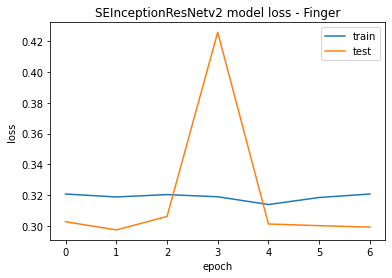

In [51]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('SEInceptionResNetv2 model loss - Finger')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(filepath+'seinceploss_finger',dpi = 300)
plt.show()

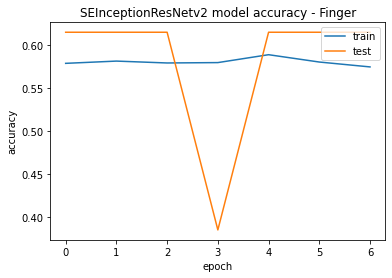

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SEInceptionResNetv2 model accuracy - Finger')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(filepath+'seincepacc_finger',dpi = 300)
plt.show()

In [53]:
import cv2
def get_testdata():
    image_data = []
    x_data = []
    y_data = []
    for index, row in test_samples.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [54]:
testx1,testy1 = get_testdata()
print(testx1.shape)
print(testy1.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(511, 300, 300, 3)
(511,)


In [55]:
testy1 = list(map(int, testy1))

In [56]:
# predict probabilities for test set
y_probs = model.predict(testx1 , verbose=0)
# predict crisp classes for test set
y_classes = (y_probs > 0.5).astype('int32')


In [57]:
# reduce to 1d array
y_probs = y_probs[:, 0]
y_classes = y_classes[:, 0]

In [58]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [59]:
# accuracy: (tp + tn) / (p + n)
test_accuracy = accuracy_score(testy1, y_classes)
print('Accuracy: %f' % test_accuracy)
# precision tp / (tp + fp)
test_precision = precision_score(testy1, y_classes)
print('Precision: %f' % test_precision)
# recall: tp / (tp + fn)
test_recall = recall_score(testy1, y_classes)
print('Recall: %f' % test_recall)
# f1: 2 tp / (2 tp + fp + fn)
test_f1 = f1_score(testy1, y_classes)
print('F1 score: %f' % test_f1)
# kappa
test_kappa = cohen_kappa_score(testy1, y_classes)
print('Cohens kappa: %f' % test_kappa)
# ROC AUC
test_auc = roc_auc_score(testy1, y_probs)
print('ROC AUC: %f' % test_auc)
# confusion matrix
test_matrix = confusion_matrix(testy1, y_classes)
print(test_matrix)

Accuracy: 0.614481
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
[[314   0]
 [197   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import roc_curve
fpr_test, tpr_test, thresholds_test = roc_curve(testy1, y_probs)

In [ ]:
from sklearn.metrics import auc
auc_test = auc(fpr_test, tpr_test)

In [ ]:
from sklearn.metrics import precision_recall_curve
test_precision, test_recall, thresholds = precision_recall_curve(testy1, y_probs)

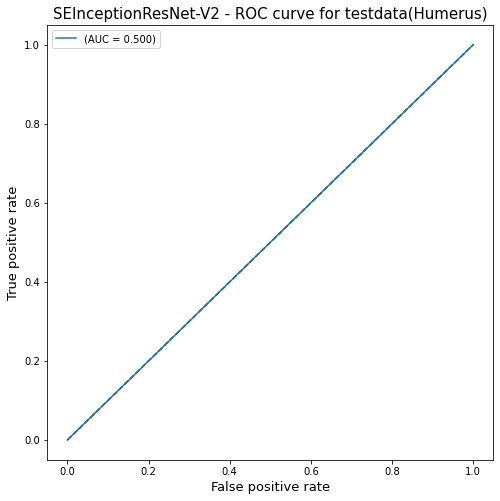

In [ ]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='(AUC = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('SEInceptionResNet-V2 - ROC curve for testdata(Humerus)',fontsize=15)
plt.legend(loc='best')
plt.show()

In [ ]:
import cv2
def get_data():
    image_data = []
    x_data = []
    y_data = []
    for index, row in valid_df.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [ ]:
testX,testY = get_data()
testY = list(map(int, testY))


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(testX , verbose=0)
# predict crisp classes for test set
yhat_classes = (yhat_probs > 0.5).astype('int32')


In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
print(yhat_probs)

In [ ]:
print(yhat_classes)

In [ ]:
print(testY)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)

In [ ]:
# kappa
kappa = cohen_kappa_score(testY, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testY, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testY, yhat_classes)
print(matrix)

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, yhat_probs)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('Baseline Approach - ROC curve for Validationdata(Humerus)',fontsize=15)
plt.legend(loc='best')
plt.show()
